# Ejercicio 2

## 2.1. Cargar los datos en un DataFrame

El primer paso consiste en cargar los datos de los .JSON en un dataframe para poder trabajar eficientemente con pandas.

In [19]:
import pandas as pd
import json
import os

# Ruta base donde están las carpetas con los hilos de los subreddits
ruta_base = r'.\Threads'

# Lista para almacenar los datos de los hilos
data_hilos = []

# Recorrer todas las carpetas de subreddits
for carpeta in os.listdir(ruta_base):
    ruta_carpeta = os.path.join(ruta_base, carpeta)

    if os.path.isdir(ruta_carpeta):  # Verificar que sea una carpeta
        for archivo in os.listdir(ruta_carpeta):
            if archivo.endswith('.json'):  # Cargar solo archivos .json
                ruta_archivo = os.path.join(ruta_carpeta, archivo) 
                
                with open(ruta_archivo, 'r', encoding='utf-8') as file:
                    hilo_data = json.load(file)  # Cargar archivo JSON
                    
                    # Agregar los campos principales y comentarios al DataFrame
                    for comment in hilo_data.get('comments', []):
                        data_hilos.append({
                            'subreddit': carpeta,
                            'hilo_titulo': hilo_data.get('title', ''),
                            'hilo_autor': hilo_data.get('author', ''),
                            'hilo_puntuacion': hilo_data.get('score', 0),
                            'hilo_descripcion': hilo_data.get('description', ''),
                            'comentario_autor': comment.get('author', ''),
                            'comentario_body': comment.get('body', ''),
                            'comentario_puntuacion': comment.get('score', 0),
                            'comentario_fecha': comment.get('created_utc', 0)
                        })

# Crear DataFrame con todos los datos
df_hilos = pd.DataFrame(data_hilos)

# Mostrar las primeras filas del DataFrame
# print(f"Datos cargados: {df_hilos.shape[0]} comentarios.")
# print(df_hilos.head())


In [17]:
# Mostrar estructura del DataFrame
print(df_hilos.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3862 entries, 0 to 3861
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   subreddit              3862 non-null   object 
 1   hilo_titulo            3862 non-null   object 
 2   hilo_autor             3862 non-null   object 
 3   hilo_puntuacion        3862 non-null   int64  
 4   hilo_descripcion       3862 non-null   object 
 5   comentario_autor       3862 non-null   object 
 6   comentario_body        3862 non-null   object 
 7   comentario_puntuacion  3862 non-null   int64  
 8   comentario_fecha       3862 non-null   float64
dtypes: float64(1), int64(2), object(6)
memory usage: 271.7+ KB
None


## 2.2. Analisis Textual

En este apartado limpiaremos el texto dentro de los archivos .json descargados por el script.
Se limpiaran de los datos carcateres especiales, hastags, menciones, y otras cadenas de texto como '[Deleted]', URLs etc.
También se normalizará el texto a minúsculas.

In [3]:
import re

# Función para limpiar texto
def limpiar_texto(texto):
    if not isinstance(texto, str):
        return ""

    # Convertir a minúsculas
    texto = texto.lower()

    # Eliminar URLs
    texto = re.sub(r'http\S+|www.\S+', '', texto)

    # Eliminar menciones de usuarios (e.g., @nombre)
    texto = re.sub(r'@\w+', '', texto)

    # Eliminar hashtags
    texto = re.sub(r'#\w+', '', texto)

    # Eliminar texto entre corchetes como [deleted], [removed]
    texto = re.sub(r'\[.*?\]', '', texto)

    # Eliminar caracteres especiales, excepto apóstrofes dentro de palabras y guiones
    texto = re.sub(r"[^\w\s'-]", '', texto)

    # Eliminar múltiples espacios
    texto = re.sub(r'\s+', ' ', texto).strip()

    return texto

# Aplicar limpieza al DataFrame
def limpiar_dataframe(df):
    columnas_texto = ['hilo_titulo', 'hilo_descripcion', 'comentario_body']

    for columna in columnas_texto:
        df[columna] = df[columna].apply(limpiar_texto)  # Reemplaza el contenido de las columnas originales

    return df

# Aplicar la limpieza mejorada al DataFrame
df_hilos = limpiar_dataframe(df_hilos)

# Mostrar un resumen de las columnas limpias
print(df_hilos[['hilo_titulo', 'comentario_body']].head())

#imprimir el numero de comentarios
print(f"Datos cargados: {df_hilos.shape[0]} comentarios.")


                                         hilo_titulo  \
0  askhistorians has a policy of zero tolerance f...   
1  askhistorians has a policy of zero tolerance f...   
2  askhistorians has a policy of zero tolerance f...   
3  askhistorians has a policy of zero tolerance f...   
4  askhistorians has a policy of zero tolerance f...   

                                     comentario_body  
0  thank you for your strong stance on this issue...  
1     i wish all of reddit were as ethical thank you  
2  quite a few questions are being asked here and...  
3  it took me a while to get my head round seeing...  
4  to add to a reply i've made to the moderators ...  
Datos cargados: 3762 comentarios.


## 2.3. Transformación a representación numérica

Una vez los textos han sido preprocesados, se procede a transformarlos a una representación numérica para ser utilizados por los modelos de clasificación. Existen varias maneras de transformar los textos en vectores. En este caso, se implementarán las siguientes representaciones:

- Bag of Words (BoW): Utiliza CountVectorizer para convertir los textos en una matriz de frecuencias, donde cada celda representa el número de veces que una palabra aparece en el documento.
- TF-IDF (Term Frequency - Inverse Document Frequency):Utiliza TfidfVectorizer para ponderar las palabras según su importancia en el documento y en el corpus completo. Esta representación reduce la influencia de palabras muy frecuentes pero poco informativas.
- Embeddings con Transformers (BERT): Utiliza un modelo preentrenado (como BERT) para generar vectores contextuales de cada texto. Estos vectores capturan no solo la presencia de palabras, sino también sus relaciones semánticas en el contexto de la frase.

A continuación, se procede a separar los datos en conjunto de entrenamiento (train) y conjunto de prueba (test), con una proporción de 70-30.



In [20]:
from sklearn.model_selection import train_test_split

# Seleccionar las columnas del DataFrame que contienen los textos y etiquetas
X = df_hilos['comentario_body'].values  # Los comentarios limpios
y = df_hilos['subreddit'].values  # Las etiquetas (subreddits)

# Dividir el conjunto de datos en entrenamiento (70%) y prueba (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Tamaño de X_train: {len(X_train)}, X_test: {len(X_test)}")

Tamaño de X_train: 2703, X_test: 1159


### 2.3.1 Transformación con BoW

Este modelo se probará con random forest, para el cual se hará una búsqueda de hiperparámetros para encontrar la mejor configuración.
Seleccionamos 5000 palabras del corpus.

In [22]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

# === 1. Transformación a BoW ===
vectorizador_bow = CountVectorizer(max_features=5000)  # Limitamos a 5000 palabras más frecuentes
X_train_bow = vectorizador_bow.fit_transform(X_train)  # Convertimos el conjunto de entrenamiento a BoW
X_test_bow = vectorizador_bow.transform(X_test)  # Convertimos el conjunto de prueba a BoW

# === 2. Búsqueda de hiperparámetros con GridSearchCV ===
param_grid_rf = {
    'n_estimators': [50, 100, 200],  # Número de árboles en el bosque
    'max_depth': [10, 20, None],  # Profundidad máxima de los árboles
    'min_samples_split': [2, 5],  # Mínimo de muestras para dividir un nodo
    'min_samples_leaf': [1, 2, 4],  # Mínimo de muestras necesarias en una hoja
    'bootstrap': [True, False]  # Si se realiza muestreo con reemplazo
}

# Creamos el modelo base de Random Forest
rf = RandomForestClassifier(random_state=42)

# Búsqueda de hiperparámetros
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=3, n_jobs=-1, verbose=2)
grid_search_rf.fit(X_train_bow, y_train)  # Ajuste del modelo

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros Random Forest (BoW):", grid_search_rf.best_params_)

# Entrenar el modelo optimizado con los mejores hiperparámetros
best_rf = grid_search_rf.best_estimator_
best_rf.fit(X_train_bow, y_train)


Fitting 3 folds for each of 108 candidates, totalling 324 fits
Mejores hiperparámetros Random Forest (BoW): {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}


RandomForestClassifier(bootstrap=False, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=200, random_state=42)

### 2.3.2 Representación TF-IDF con SVM

En primer lugar se transforman los textos de X_train y X_test a su representación TF-IDF.

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

# === Transformación a TF-IDF ===
vectorizador_tfidf = TfidfVectorizer(max_features=5000)  # Limita el vocabulario a las 5000 palabras más importantes
X_train_tfidf = vectorizador_tfidf.fit_transform(X_train)  # Transformar conjunto de entrenamiento
X_test_tfidf = vectorizador_tfidf.transform(X_test)  # Transformar conjunto de prueba

print(f"Tamaño de X_train_tfidf: {X_train_tfidf.shape}, X_test_tfidf: {X_test_tfidf.shape}")

Tamaño de X_train_tfidf: (2703, 5000), X_test_tfidf: (1159, 5000)


Ahora buscamos los mejores parámetros con GridSearch

In [25]:
from sklearn.svm import SVC

# === Búsqueda de hiperparámetros para SVM ===
param_grid_svm = {
    'C': [0.1, 1, 10],  # Parámetro de regularización
    'kernel': ['linear', 'rbf'],  # Tipo de kernel
    'gamma': ['scale', 'auto'],  # Parámetro gamma (para kernels no lineales)
}

# Creamos el modelo base de SVM
svm = SVC(random_state=42)

# Búsqueda de hiperparámetros
grid_search_svm = GridSearchCV(estimator=svm, param_grid=param_grid_svm, cv=3, n_jobs=-1, verbose=2)
grid_search_svm.fit(X_train_tfidf, y_train)  # Ajuste del modelo

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros SVM (TF-IDF):", grid_search_svm.best_params_)

# Entrenar el modelo optimizado con los mejores hiperparámetros
best_svm = grid_search_svm.best_estimator_
best_svm.fit(X_train_tfidf, y_train)


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Mejores hiperparámetros SVM (TF-IDF): {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


SVC(C=10, random_state=42)

### 2.3.3 Modelo con transformers (BERT)

Se realizan los siguientes pasos:


1. Transformación de los textos usando AutoTokenizer (para convertir texto a tokens).
2. Entrenamiento con AutoModelForSequenceClassification (clasificación con BERT).
3. Evaluación del modelo con Trainer de HuggingFace

#### 2.3.3.1 Preparación del modelo preentrenado y codificación de etiquetas usando AutoTokenizer

Elegimos el modelo 'bert-base-uncased', dado que es el indicado para textos en inglés en minúscula.

In [18]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.preprocessing import LabelEncoder

# === 1. Selección del modelo preentrenado ===
modelo_transformer = 'bert-base-uncased'  # BERT en inglés
tokenizer = AutoTokenizer.from_pretrained(modelo_transformer)
model = AutoModelForSequenceClassification.from_pretrained(modelo_transformer, num_labels=len(set(y_train)))

# === 2. Codificación de etiquetas ===
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

C:\Users\JavierGS\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### 2.3.3.2 Tokenización de los textos y creación de datasets

In [19]:
import torch

# === 3. Tokenización de los textos ===
X_train_tokens = tokenizer(list(X_train), truncation=True, padding=True, max_length=512, return_tensors="pt")
X_test_tokens = tokenizer(list(X_test), truncation=True, padding=True, max_length=512, return_tensors="pt")

# Dataset personalizado para HuggingFace
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

# Crear datasets de entrenamiento y prueba
train_dataset = TextDataset(X_train_tokens, y_train_encoded)
test_dataset = TextDataset(X_test_tokens, y_test_encoded)


#### 2.3.3.3 Configuración de parámetros de entrenamiento

In [20]:
from transformers import TrainingArguments

# === 4. Parámetros de entrenamiento ===
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",  # Solo evaluar al final de cada época
    logging_steps=50,  # Menos pasos de logging para evitar interrupciones frecuentes
    save_strategy="epoch",
    learning_rate=8e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="./logs",
    report_to="none",  # Evitar reportes externos
    fp16 = True
)

# Verificar el dispositivo de entrenamiento
import torch
print(f"Entrenando en: {'GPU' if torch.cuda.is_available() else 'CPU'}")


Entrenando en: GPU


C:\Users\JavierGS\AppData\Roaming\Python\Python312\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


#### 2.3.3.4 Entrenamiento del modelo con BERT

In [21]:
from transformers import Trainer

# === 5. Entrenador ===
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# === 6. Entrenamiento ===
print("Entrenando el modelo con BERT...")
trainer.train()


Entrenando el modelo con BERT...


Epoch,Training Loss,Validation Loss
1,2.007700,0.912662
2,0.764700,0.714396
3,0.496800,0.721074
4,0.251100,0.732581
5,0.185200,0.720254


TrainOutput(global_step=415, training_loss=0.6482265943504242, metrics={'train_runtime': 39667.0224, 'train_samples_per_second': 0.332, 'train_steps_per_second': 0.01, 'total_flos': 3464105848412160.0, 'train_loss': 0.6482265943504242, 'epoch': 5.0})

Guardamos el modelo para poder cargarlo sin necesidad de entrenarlo de nuevo

In [22]:
# === Guardar el modelo entrenado ===
ruta_guardado = "./Modelo_BETO"
trainer.save_model(ruta_guardado)  # Guarda los pesos, configuraciones y tokenizador
print(f"Modelo guardado en: {ruta_guardado}")

Modelo guardado en: ./Modelo_BETO


Carga del modelo:

In [ ]:
# from transformers import AutoModelForSequenceClassification, AutoTokenizer

# # Ruta donde guardaste el modelo
# ruta_cargada = "./modelo_transformers_beto"

# # Cargar modelo y tokenizador desde la ruta local
# tokenizer = AutoTokenizer.from_pretrained(ruta_cargada)
# model = AutoModelForSequenceClassification.from_pretrained(ruta_cargada)

## 2.4. Evaluación de los modelos 

A continuación se muestran los resultados de los distintos modelos entrenados.

### 2.4.1. Evaluación del modelo RandomForest (BoW)

In [ ]:
from sklearn.metrics import classification_report

# Predicciones del modelo Random Forest (BoW)
y_pred_rf = best_rf.predict(X_test_bow)

print("=== Reporte de clasificación Random Forest (BoW) ===")
print(classification_report(y_test, y_pred_rf))


=== Reporte de clasificación Random Forest (BoW) ===
               precision    recall  f1-score   support

AskHistorians       0.59      0.32      0.42       109
   AskPhysics       0.79      0.69      0.74       109
      Cooking       0.66      0.61      0.64       100
      Fitness       0.50      0.57      0.53       104
LetsTalkMusic       0.82      0.78      0.80       124
  TravelHacks       0.87      0.68      0.76       122
askphilosophy       0.44      0.69      0.53       113
askpsychology       0.59      0.51      0.55       125
      nosleep       0.41      0.54      0.47       114
     preppers       0.51      0.55      0.53       109

     accuracy                           0.60      1129
    macro avg       0.62      0.59      0.60      1129
 weighted avg       0.62      0.60      0.60      1129



Tenemos un accuracy de 0.62, como veremos más adelante, inferior al resto de modelos.

### 2.4.2. Evaluación del modelo SVM (TF-IDF)

In [33]:
# Predicciones del modelo SVM (TF-IDF)
y_pred_svm = best_svm.predict(X_test_tfidf)

print("=== Reporte de clasificación SVM (TF-IDF) ===")
print(classification_report(y_test, y_pred_svm))


=== Reporte de clasificación SVM (TF-IDF) ===
               precision    recall  f1-score   support

AskHistorians       0.84      0.43      0.57       109
   AskPhysics       0.67      0.78      0.72       109
      Cooking       0.75      0.61      0.67       100
      Fitness       0.60      0.70      0.65       104
LetsTalkMusic       0.84      0.75      0.79       124
  TravelHacks       0.79      0.68      0.73       122
askphilosophy       0.50      0.69      0.58       113
askpsychology       0.65      0.60      0.62       125
      nosleep       0.59      0.54      0.57       114
     preppers       0.48      0.67      0.56       109

     accuracy                           0.65      1129
    macro avg       0.67      0.65      0.65      1129
 weighted avg       0.67      0.65      0.65      1129



Este modelo se comporta mejor que el anterior (RF y BoW), aunque muy por debajo del rendimiento del transformer.

### 2.4.3. Evaluación del modelo BERT (Transformers)

In [30]:
# Predicciones del modelo BERT
preds = trainer.predict(test_dataset)
y_pred_bert = preds.predictions.argmax(axis=1)

print("=== Reporte de clasificación BERT (Transformers) ===")
print(classification_report(y_test_encoded, y_pred_bert))

=== Reporte de clasificación BERT (Transformers) ===
              precision    recall  f1-score   support

           0       0.77      0.72      0.74       109
           1       0.90      0.87      0.89       109
           2       0.90      0.80      0.85       100
           3       0.84      0.81      0.82       104
           4       0.96      0.88      0.92       124
           5       0.89      0.84      0.86       122
           6       0.57      0.91      0.70       113
           7       0.83      0.76      0.79       125
           8       0.82      0.66      0.73       114
           9       0.75      0.81      0.78       109

    accuracy                           0.81      1129
   macro avg       0.82      0.80      0.81      1129
weighted avg       0.82      0.81      0.81      1129



Como se puede observar, el rendimiento con transformers es muy superior a los obtenidos con BoW + RF y TF-IDF + SVM

### 2.4.4. Visualización de matrices de confusión

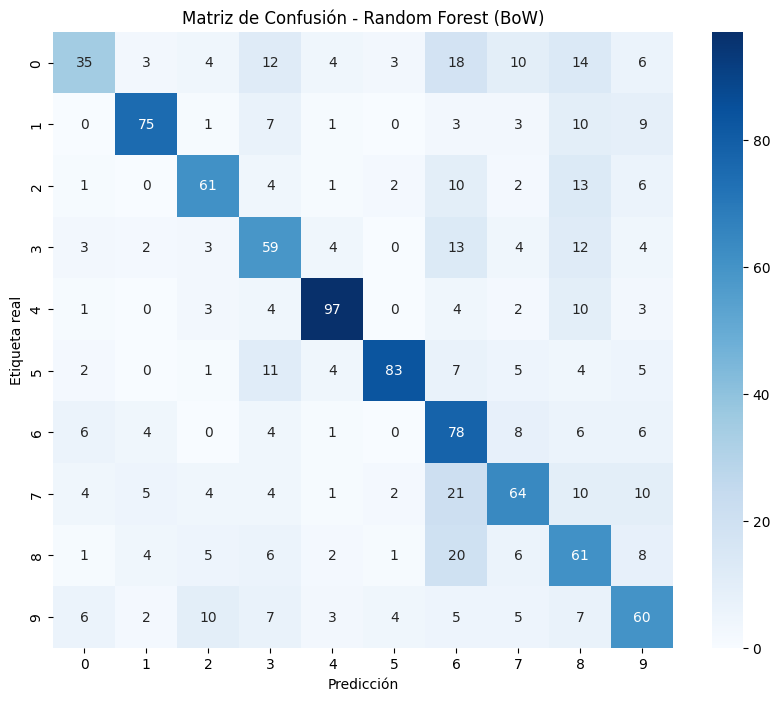

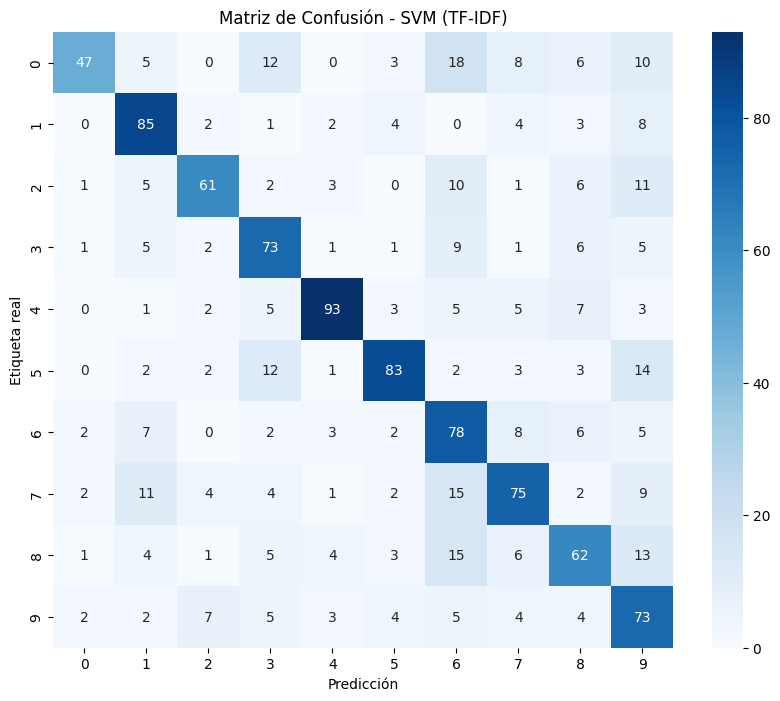

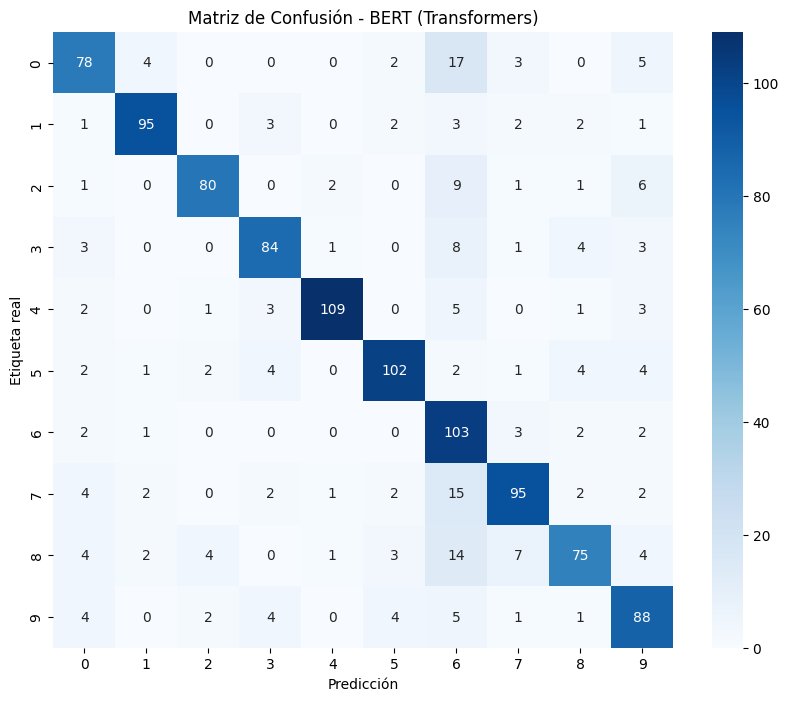

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicción')
    plt.ylabel('Etiqueta real')
    plt.title(f'Matriz de Confusión - {title}')
    plt.show()

# Matrices de confusión
plot_confusion_matrix(y_test, y_pred_rf, "Random Forest (BoW)")
plot_confusion_matrix(y_test, y_pred_svm, "SVM (TF-IDF)")
plot_confusion_matrix(y_test_encoded, y_pred_bert, "BERT (Transformers)")


## 2.5. Conclusión

En este experimento queda demostrada la superioridad de rendimiento a la hora de analizar texto que tienen los modelos basados en transformers, cuando se comparan con modelos clásicos y representaciones vectoriales. En las matrices de confusión se puede apreciar como las predicciones son notablemente más precisas en el experimento utilizando BERT.

El resultado obtenido refuerza la idea presentada en la introducción del ejercicio.

1. BoW se limita a establecer una matriz donde queda representada la frecuencia con la que aparece cada palabra en los textos analizados.
2. TF-IDF pondera las palabras según la importancia, lo cual es más relevante que la frecuencia como hace BoW, por lo que tiene sentido su mayor precisión.
3. BERT, o los modelos de transformer en general, establece relaciones semánticas entre las palabras, con lo que tiene una capacidad de análisis superior, y eso queda reflejado en la precisión.

No obstante, los tiempos de entrenamiento con BERT son muy superiores con respecto a los otros experimentos (11h vs algunos minutos).

# Ejercicio 5

En este ejercicio se emplearán los conocidos como SLM (Small Large Models) con el objetivo de clasificar comentarios como ofensivos o no ofensivos.

Se emplearán 3 técnicas diferentes:

1. Zero Shot Learning (ZSL)
2. Few Shot Learning (FSL)
3. Chain of Thought (CoT)

Para emplear las tres técnicas se hará uso de un único modelo, Llama 3.2.

Finalmente se comparará el rendimiento obtenido con cada una de las técnicas.

## 5.1. Preparación del modelo Llama

Descargamos el modelo desde Hugging Face y cargamos el tokenizer.

In [ ]:
# === Instalación e Importación de librerías ===
# !pip install transformers accelerate
from huggingface_hub import login
from transformers import AutoTokenizer, AutoModelForCausalLM

token_hf = ""   # Introducir token de acceso de Hugging Face
login(token=token_hf)

# === 1. Preparación del modelo Llama 3.2 (1B) ===
modelo_llama = 'meta-llama/Llama-3.2-1B'  # Reemplaza con el modelo elegido

# Cargar el tokenizador y el modelo
tokenizer = AutoTokenizer.from_pretrained(modelo_llama)
model = AutoModelForCausalLM.from_pretrained(modelo_llama, device_map="auto")

print("Modelo Llama cargado correctamente.")

C:\Users\JavierGS\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some parameters are on the meta device because they were offloaded to the cpu.


Modelo Llama cargado correctamente.


## 5.2. Zero-Shot-Learning (ZSL)
Zero-shot Learning (ZSL) se refiere a la capacidad de un modelo de resolver tareas para las que no ha recibido ejemplos de entrenamiento. En este caso, se le formula un prompt con instrucciones para clasificar un texto ofensivo o no ofensivo, sin aportar ejemplos extra.

Por ejemplo:

> Entrada: "Is the next comment offensive or not?: You are a bastard and deserve death, go to hell!"

> Respuesta esperada: "Yes".

El modelo debe inferir directamente la respuesta sin necesidad de haber visto ejemplos antes.

In [15]:
from transformers import AutoTokenizer, AutoModelForCausalLM

# Carga del modelo y tokenizer
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.2-1B")  # Ajusta con tu modelo
model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-3.2-1B")

# Función para evaluar ZSL con tensores
def evaluate_zsl(model, tokenizer, prompt):
    inputs = tokenizer(prompt, return_tensors="pt")  # Convertimos a tensores
    outputs = model.generate(**inputs, max_length=200)
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    print(f"\n-----------------------\nRespuesta del modelo: {response}")

# Prompt de ejemplo para ZSL
comentario = "you are a bastard and deserve death, go to hell!"  # Comentario ofensivo
prompt_zsl = f"""
you are a classifier that determines whether a given text is offensive or non-offensive without any explanation. 
offensive refers to abusive, aggressive, or violent language targeting a person or group based on attributes like race, ethnicity,
 religion, gender, sexual orientation, disability, or other protected characteristics.
Task:
Given the text input, return one of the two labels:
offensive: If the text contains offensive or discriminatory language targeting individuals or groups based on identity or protected characteristics.
non-offensive: If the text is free from such language or does not target a person or group in a harmful way. 
Text: '{comentario}'"""
resultado_zsl = evaluate_zsl(model, tokenizer, prompt_zsl)


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



-----------------------
Respuesta del modelo: 
you are a classifier that determines whether a given text is offensive or non-offensive without any explanation. 
offensive refers to abusive, aggressive, or violent language targeting a person or group based on attributes like race, ethnicity,
 religion, gender, sexual orientation, disability, or other protected characteristics.
Task:
Given the text input, return one of the two labels:
offensive: If the text contains offensive or discriminatory language targeting individuals or groups based on identity or protected characteristics.
non-offensive: If the text is free from such language or does not target a person or group in a harmful way. 
Text: 'you are a bastard and deserve death, go to hell!' 
Output: offensive

Text: 'you are a bastard and deserve death, go to hell!' 
Output: non-offensive

Text: 'i'm a racist and hate blacks!' 
Output: offensive



Como podemos ver, el modelo no es capaz de clasificar adecuadamente el comentario. Parece que entiende lo que quiere decir que un comentario sea ofensivo, ya que tras responder ha creado un nuevo comentario ofensivo, pero no es capaz de entender al 100% lo que se le pide en la tarea.

Las respuestas que da son variadas pero nunca tienen sentido. La mayoria de veces repite el prompt, otras escribe enlaces falsos, otras escribe un montón de palabras sin sentido etc.

Se han hecho muchos intentos con isntrucciones distintas en el prompt, siendo este, que proviene del aula virtual en el ejemplo de ZSL, el que mejor resultado ha dado. 


## 5.3. Few-Shot-Learning (FSL)

Few-shot Learning (FSL) consiste en dar al modelo unos pocos ejemplos de contexto antes de hacer la pregunta. Esto ayuda al modelo a tener una referencia más clara sobre cómo debería clasificar el texto. Se va a realizar el mismo experimento, con la misma lista de comentarios del apartado anterior, pero esta vez en cada prompt tendremos una serie de frases de contexto para que el modelo aprenda a clasificar correctamente antes de responder.

In [4]:
# Función para evaluar FSL
def evaluate_fsl(model, tokenizer, prompt):
    inputs = tokenizer(prompt, return_tensors="pt")  # Convertimos a tensores
    outputs = model.generate(**inputs, max_new_tokens=20)
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    print(f"\n-----------------------\nRespuesta del modelo: {response}")

# Nuevos ejemplos ofensivos y no ofensivos más explícitos
contexto_fsl = (
    "Classify comment 11. as Offensive or Not offensive. Only answer with Offensive or Not offensive:\n\n"
    "Comment 1. 'You're a breath of fresh air in this project!' -> Not Offensive.\n"
    "Comment 2. 'Go die in a ditch, you scumbag!' -> Offensive.\n"
    "Comment 3. 'I completely disagree with your point, but I see your reasoning.' -> Not Offensive.\n"
    "Comment 4. 'You’re an incompetent fool who ruins everything!' -> Offensive.\n"
    "Comment 5. 'Thank you so much for your thoughtful input!' -> Not Offensive.\n"
    "Comment 6. 'You're an absolute piece of trash, get lost!' -> Offensive.\n"
    "Comment 7. 'This meeting was productive, I really appreciate it.' -> Not Offensive.\n"
    "Comment 8. 'You dumb idiot, you’ve got no brains!' -> Offensive.\n"
    "Comment 9. 'We all have different perspectives, and that’s valid.' -> Not Offensive.\n"
    "Comment 10. 'You’re a pathetic loser with no friends!' -> Offensive.\n"
)

# Ejemplo de comentario ofensivo
prompt_fsl = contexto_fsl + f"Comment 11: '{comentario}' ->"
prediccion = evaluate_fsl(model, tokenizer, prompt_fsl)


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



-----------------------
Respuesta del modelo: Classify comment 11. as Offensive or Not offensive. Only answer with Offensive or Not offensive:

Comment 1. 'You're a breath of fresh air in this project!' -> Not Offensive.
Comment 2. 'Go die in a ditch, you scumbag!' -> Offensive.
Comment 3. 'I completely disagree with your point, but I see your reasoning.' -> Not Offensive.
Comment 4. 'You’re an incompetent fool who ruins everything!' -> Offensive.
Comment 5. 'Thank you so much for your thoughtful input!' -> Not Offensive.
Comment 6. 'You're an absolute piece of trash, get lost!' -> Offensive.
Comment 7. 'This meeting was productive, I really appreciate it.' -> Not Offensive.
Comment 8. 'You dumb idiot, you’ve got no brains!' -> Offensive.
Comment 9. 'We all have different perspectives, and that’s valid.' -> Not Offensive.
Comment 10. 'You’re a pathetic loser with no friends!' -> Offensive.
Comment 11: 'You are a bastard and deserve death, go to hell!' -> Offensive.
Comment 12. 'You're

Como se puede ver en el output recibido, el modelo es capaz de clasificar el comentario de ejemplo como ofensivo, sin embargo no es capaz de entender las instrucciones pedidas para generar la respuesta. Se limita a copiar los ejemplos y continuar la serie, a pesar de que se le ha pedido que responda únicamente con Offensive o Not Offensive.

Al igual que en el apartado anterior, se han hecho varias pruebas, y el resultado suele ser el presentado, aunque a veces comienza a escribir frases sin sentido después de responder.

In [5]:
import re

# Función para evaluar FSL
def evaluate_fsl(model, tokenizer, prompt):
    inputs = tokenizer(prompt, return_tensors="pt")
    outputs = model.generate(**inputs, max_new_tokens=20)  # Limitamos la longitud de la respuesta
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    print(response)
    return "no" if "not offensive" in response.lower() else "sí"

# Nuevos ejemplos ofensivos y no ofensivos más explícitos en minúsculas y sin signos de exclamación
contexto_fsl = (
    "classify comment 11 as offensive or not offensive. only answer <not offensive> or <offensive>:\n\n"
    "comment 1. 'you're a breath of fresh air in this project' -> not offensive.\n"
    "comment 2. 'go die in a ditch, you scumbag' -> offensive.\n"
    "comment 3. 'i completely disagree with your point, but i see your reasoning' -> not offensive.\n"
    "comment 4. 'you’re an incompetent fool who ruins everything' -> offensive.\n"
    "comment 5. 'thank you so much for your thoughtful input' -> not offensive.\n"
    "comment 6. 'you're an absolute piece of trash, get lost' -> offensive.\n"
    "comment 7. 'this meeting was productive, i really appreciate it' -> not offensive.\n"
    "comment 8. 'you dumb idiot, you’ve got no brains' -> offensive.\n"
    "comment 9. 'we all have different perspectives, and that’s valid' -> not offensive.\n"
    "comment 10. 'you’re a pathetic loser with no friends' -> offensive.\n"
)

# Evaluar un solo prompt (comentarios en minúsculas y sin signos de exclamación)
comentario = "you are an amazing person"  # Comentario no ofensivo
prompt_fsl = contexto_fsl + f"comment 11: '{comentario}' ->"
# print(f"Prompt FSL: {prompt_fsl}")
resultado_fsl = evaluate_fsl(model, tokenizer, prompt_fsl)
print(f"Resultado FSL: {resultado_fsl}")

# Evaluar otro prompt ofensivo
comentario = "you are a bastard and you should die of cancer, go to hell"  # Comentario ofensivo
prompt_fsl = contexto_fsl + f"comment 11. '{comentario}' ->"
# print(f"Prompt FSL: {prompt_fsl}")
resultado_fsl = evaluate_fsl(model, tokenizer, prompt_fsl)
print(f"Resultado FSL: {resultado_fsl}")


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


classify comment 11 as offensive or not offensive. only answer <not offensive> or <offensive>:

comment 1. 'you're a breath of fresh air in this project' -> not offensive.
comment 2. 'go die in a ditch, you scumbag' -> offensive.
comment 3. 'i completely disagree with your point, but i see your reasoning' -> not offensive.
comment 4. 'you’re an incompetent fool who ruins everything' -> offensive.
comment 5. 'thank you so much for your thoughtful input' -> not offensive.
comment 6. 'you're an absolute piece of trash, get lost' -> offensive.
comment 7. 'this meeting was productive, i really appreciate it' -> not offensive.
comment 8. 'you dumb idiot, you’ve got no brains' -> offensive.
comment 9. 'we all have different perspectives, and that’s valid' -> not offensive.
comment 10. 'you’re a pathetic loser with no friends' -> offensive.
comment 11: 'you are an amazing person' -> not offensive.

Resultado FSL: no
classify comment 11 as offensive or not offensive. only answer <not offensive>

Véase en este último caso, como tras responder al comentario ofensivo, aunque lo clasifica bien, el modelo genera texto sin sentido después.

Para evaluar la precisión del modelo de forma quantitativa para esta tarea, se realiza un bucle en el que se hacen 20 prompts y se calcula con qué precisión es capaz de responder correctamente, pero resulta imprescindible realizar post-procesamiento a la salida, dado que las respuestas, aunque puedan ser correctas, pueden estar contaminadas por texto extra que el modelo añade al final.

In [7]:
import re
import pandas as pd

# Función para evaluar FSL con post-procesamiento
def evaluate_fsl_loop(model, tokenizer, prompt, comentario):
    inputs = tokenizer(prompt, return_tensors="pt")
    # print(f"Prompt FSL: {prompt}")
    outputs = model.generate(**inputs, max_length=230)
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    # print(f"\n-----------------------\nRespuesta del modelo: {response}")

    # Post-procesamiento: buscar el comentario exacto y extraer la respuesta después del primer "->"
    pattern = rf"{re.escape(comentario)}'\s*->\s*(.*?)(\.|$)"
    match = re.search(pattern, response)
    if match:
        extracted_text = match.group(1).strip().lower()
        if "not offensive" in extracted_text:
            return "no"
        elif "offensive" in extracted_text:
            return "si"
    print(f"Respuesta no encontrada: {response}")
    return "inconcluso"

# Contexto de ejemplos FSL en minúsculas y sin signos de exclamación
contexto_fsl = (
    "classify comment 11 as offensive or not offensive:\n\n"
    "comment 1. 'you're an incredible teammate' -> not offensive.\n"
    "comment 2. 'go die in a ditch, you scumbag' -> offensive.\n"
    "comment 3. 'i completely disagree with your point, but i see your reasoning' -> not offensive.\n"
    "comment 4. 'you’re a worthless idiot who ruins everything' -> offensive.\n"
    "comment 5. 'thank you so much for your thoughtful input' -> not offensive.\n"
    "comment 6. 'you're an absolute moron, get lost' -> offensive.\n"
    "comment 7. 'this meeting was productive, i really appreciate it' -> not offensive.\n"
    "comment 8. 'you brainless piece of garbage' -> offensive.\n"
    "comment 9. 'we all have different perspectives, and that’s valid' -> not offensive.\n"
    "comment 10. 'you’re a pathetic waste of space' -> offensive.\n"
)

# Lista de comentarios con etiquetas reales (ofensivos o no), todo en minúsculas y sin signos de exclamación
comentarios_data = [
    ("you are an amazing person", "no"),
    ("you stupid idiot, get a life", "si"),
    ("good morning, i hope you have a wonderful day", "no"),
    ("you are a useless piece of trash", "si"),
    ("thanks for your help, i really appreciate it", "no"),
    ("you're a pathetic loser who can't do anything right", "si"),
    ("i believe in your potential, keep going", "no"),
    ("nobody likes you, you disgusting freak", "si"),
    ("you're an essential part of this team, thank you", "no"),
    ("you're a total embarrassment to everyone", "si"),
    ("hope you recover soon, take care", "no"),
    ("shut up, you idiot, nobody cares about you", "si"),
    ("great job, i admire your work", "no"),
    ("you useless waste of air, get out of here", "si"),
    ("congratulations on your promotion", "no"),
    ("you are a complete disgrace", "si"),
    ("such a thoughtful message, thank you", "no"),
    ("why don't you crawl back to where you came from, loser", "si"),
    ("let's collaborate to solve this", "no"),
    ("you're an utter failure", "si"),
]


# Bucle de evaluación FSL
resultados = []

for idx, (comentario, etiqueta_real) in enumerate(comentarios_data):
    prompt_fsl = contexto_fsl + f"comment 11. {comentario}' ->"
    prediccion = evaluate_fsl_loop(model, tokenizer, prompt_fsl, comentario)
    # print(f"comentario: {comentario} - real: {etiqueta_real} - predicción: {prediccion}")
    resultados.append({"comentario": comentario, "real": etiqueta_real, "predicción": prediccion})

# Creación de DataFrame
df_resultados = pd.DataFrame(resultados)

# Mostrar la tabla con los resultados
print(df_resultados)

# Opcional: Calcular precisión
aciertos = sum(df_resultados["real"] == df_resultados["predicción"])
precision = aciertos / len(df_resultados)
print(f"precisión del modelo FSL: {precision:.2f}")


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

                                           comentario real predicción
0                           you are an amazing person   no         no
1                        you stupid idiot, get a life   si         si
2       good morning, i hope you have a wonderful day   no         no
3                    you are a useless piece of trash   si         si
4        thanks for your help, i really appreciate it   no         no
5   you're a pathetic loser who can't do anything ...   si         si
6             i believe in your potential, keep going   no         no
7              nobody likes you, you disgusting freak   si         si
8    you're an essential part of this team, thank you   no         no
9            you're a total embarrassment to everyone   si         si
10                   hope you recover soon, take care   no         no
11         shut up, you idiot, nobody cares about you   si         si
12                      great job, i admire your work   no         no
13          you usel

Finalmente, tras post-procesar las salidas del modelo, es posible crear un sistema de detección preciso, al menos para el ejemplo probado, con cadenas de texto pequeñas.

Ahora se va a proceder a realizar el mismo experimento con comentarios más largos de los .JSON descargados del subreddit de ControversialOpinions. Se ha pasado los .JSON a chatgpt para que analice todos y extraiga comentarios ofensivos, para poder realizar la clasificación. Adicionalmente, se han revisado los comentarios manualmente para asegurar que la clasificación propuesta por chatGPT sea correcta, y de hecho cometió algún error.

In [9]:
# Función para evaluar FSL con post-procesamiento
def evaluate_fsl_loop(model, tokenizer, prompt, comentario):
    inputs = tokenizer(prompt, return_tensors="pt")
    # print(f"Prompt FSL: {prompt}")
    outputs = model.generate(**inputs, max_new_tokens=50)
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    # print(f"\n-----------------------\nRespuesta del modelo: {response}")

    # Post-procesamiento: buscar el comentario exacto y extraer la respuesta después del primer "->"
    pattern = rf"{re.escape(comentario)}'\s*->\s*(.*?)(\.|$)"
    match = re.search(pattern, response)
    if match:
        extracted_text = match.group(1).strip().lower()
        if "not offensive" in extracted_text:
            return "no"
        elif "offensive" in extracted_text:
            return "si"
    print(f"Respuesta no encontrada: {response}")
    return "inconcluso"

# Contexto con comentarios reales
contexto_fsl_real = (
    "classify comment 11 as offensive or not offensive:\n\n"
    "comment 1. 'that was really beautiful op. i do hope one day see megan’s painting. the way you describe it is phenomenal.' -> not offensive.\n"
    "comment 2. 'if it’s unwarranted, keep that shit to yourself. or you won’t friend much longer.' -> offensive.\n"
    "comment 3. 'and I told you why your opinion is shit.' -> offensive.\n"
    "comment 4. 'wow... so sad. and creepy. also is not a series with stupid cliffhangers.' -> offensive.\n"
    "comment 5. 'this is the scariest story i've ever read on here and i fucking hate myself for reading it.' -> offensive.\n"
    "comment 6. 'i don't know how you could not look out that window, i can only imagine whatever was outside looked like.' -> not offensive.\n"
    "comment 7. 'this was very sad! poor stanislav. i hope olivia got a good mark out of this assignment.' -> not offensive.\n"
    "comment 8. 'i am extremely glad the larder full of food turned out to be moldy pickled stuff and not a room full of corpses.' -> not offensive.\n"
    "comment 9. 'have you ever got an iq test? This statement is so retarded i cant even comment on it' -> offensive.\n"
    "comment 10. 'wow... as a former awkward, lonely kid who found solace in drawing, your story struck a nerve.' -> not offensive.\n"
)

# Lista de comentarios de prueba (15 no ofensivos + 15 ofensivos)
comentarios_data = [
    ("you went into the house after your wife begged you not to, because you felt a sudden urge to do so", "no"),
    ("poor thomas! what is he going to do? he doesn't even know where she is!!!", "no"),
    ("iggy, ima head out after that one. i wonder what was with the closet rule?", "no"),
    ("thomas, if you want to keep your job and your life as a d personal, you have to press the green button", "no"),
    ("i'm so scared and sad for you, op. stay safe and let us know how you're doing", "no"),
    ("perhaps she was the one doing his job until she asked too many questions", "no"),
    ("i don’t expect people to agree with me. i’m explaining why I think the opposite attitude is a poor one to take. this is an opinion sub.", "no"),
    ("wow... as a former awkward, lonely kid who found solace in drawing, your story struck a nerve", "no"),
    ("i wish i could unread this so i could read it again", "no"),
    ("get a couple of shotguns and some guys; there's only two real possibilities here", "no"),
    ("op, what part of 'discretion required' is unclear?", "no"),
    ("this is one of the most haunting yet captivating stories i’ve read", "no"),
    ("this was incredibly heartfelt; thank you for sharing", "no"),
    ("your story was a rollercoaster of emotions", "no"),
    ("such a trash fucking song. no rhythm and lyrics don't flow at all with it", "si"),
    ("everything is so stupid nowadays. i saw a commercial today with a white man and black woman couple... so stupid i turned off tv", "si"),
    ("this is literally brain rot. don't talk about shit you don't know shit about", "si"),
    ("y'all are actually insane", "si"),
    ("this worst thing about this is that now it's become normal to make female characters cunts in an attempt to make them tough", "si"),
    ("feminism was always about control. some shitheads used some women to divide men and women so controlling us all is easier", "si"),
    ("you’re part of the 'not all men' ridiculousness", "si"),
    ("these debates are stupid and a waste of time. none of you are music historians", "si"),
    ("it is a joke and i now we can expect to see other rap artist try to transition to country and eventually ruin another thing of ours", "si"),
    ("i hope my man hits me back. that's equality, bitches", "si"),
    ("you are the reason people lose brain cells on the internet", "si"),
    ("another clueless post from someone who loves to hear themselves talk", "si"),
    ("you’re delusional if you think this makes any sense", "si"),
    ("stop being so self-righteous; it’s embarrassing", "si")
]

# Evaluación
resultados = []
for idx, (comentario, etiqueta_real) in enumerate(comentarios_data):
    prompt_fsl = contexto_fsl_real + f"comment 11. {comentario}' ->"
    prediccion = evaluate_fsl_loop(model, tokenizer, prompt_fsl, comentario)
    resultados.append({"comentario": comentario, "real": etiqueta_real, "predicción": prediccion})

df_resultados = pd.DataFrame(resultados)
print(df_resultados)

# Calcular precisión
aciertos = sum(df_resultados["real"] == df_resultados["predicción"])
precision = aciertos / len(df_resultados)
print(f"Precisión del modelo FSL: {precision:.2f}")


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

                                           comentario real predicción
0   you went into the house after your wife begged...   no         si
1   poor thomas! what is he going to do? he doesn'...   no         si
2   iggy, ima head out after that one. i wonder wh...   no         si
3   thomas, if you want to keep your job and your ...   no         si
4   i'm so scared and sad for you, op. stay safe a...   no         no
5   perhaps she was the one doing his job until sh...   no         si
6   i don’t expect people to agree with me. i’m ex...   no         si
7   wow... as a former awkward, lonely kid who fou...   no         si
8   i wish i could unread this so i could read it ...   no         si
9   get a couple of shotguns and some guys; there'...   no         si
10  op, what part of 'discretion required' is uncl...   no         si
11  this is one of the most haunting yet captivati...   no         no
12  this was incredibly heartfelt; thank you for s...   no         si
13         your stor

Se puede ver como el rendimiento al analizar comentarios reales es menor que con los ejemplos propuestos por chatGPT en el experimento anterior. Esto se debe en parte a que los comentarios de reddit poseen muchos de ellos un tono sarcástico, que incluso para un humano resulta ambiguo clasificar como ofensivo o no ofensivo en algunos casos. No obstante la precisión supera el 50%, lo que significa que está siendo capaz de clasificar los comentarios en cierta medida. Probablemente con una lista más extensa de comentarios de ejemplo mejoraría el desempeño.

Cabe destacar que el problema que está teniendo mayoritariamente en este experimento es que tiende a clasificar como ofensivo con mucha facilidad, algo que puede ser importante de cara a querer mejorar el rendimiento.

### 5.4. Chain-of-Thought (CoT)
Chain-of-Thought (CoT) es una estrategia para mejorar la respuesta al pedirle al modelo que explique su razonamiento antes de responder. En lugar de dar una respuesta directa ("sí" o "no"), primero se le pide al modelo que explique los motivos detrás de su respuesta.

In [13]:
# Función para evaluar CoT
def evaluate_cot(model, tokenizer, prompt):
    inputs = tokenizer(prompt, return_tensors="pt")
    outputs = model.generate(**inputs, max_new_tokens=100)  # Permitimos una respuesta más extensa para el razonamiento
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    print(f"\n-----------------------\nRespuesta del modelo: {response}")

# Prompt CoT con razonamiento
comentario = "You are a useless idiot, get out of here!"
prompt_cot = f"""
You are a classifier that determines whether a given text contains hate speech or non-hate speech without any explanation. 
Hate speech refers to abusive, aggressive, or violent language targeting a person or group based on attributes like race, ethnicity, religion, gender, sexual orientation, disability, or other protected characteristics.

Task:
Given the text input, think step-by-step about whether the text contains offensive or discriminatory language. 
Consider whether the language targets individuals or groups based on identity or protected characteristics. Then, make a final decision on whether it is "Hate Speech" or "Non-Hate Speech."

"Hate Speech": If the text contains offensive or discriminatory language targeting individuals or groups based on identity or protected characteristics.
"Non-Hate Speech": If the text is free from such language or does not target a person or group in a harmful way.

Examples:

Example 1:
Text: "All people should be treated equally, no matter their background or race."
Step-by-step reasoning: 
- The text promotes equality for all people, regardless of race.
- There is no offensive or discriminatory language.
- It does not target any group in a harmful way.
Classification: Non-Hate Speech

Example 2:
Text: "Those people are ruining our country and need to be eliminated."
Step-by-step reasoning:
- The phrase "Those people" is vague but implies targeting a specific group.
- The statement "ruining our country" is accusatory and aggressive.
- The call to "eliminate" suggests violence and harm toward the group.
- This language is harmful, aggressive, and targets a group of people.
Classification: Hate Speech

Now, classify the following text by thinking step-by-step:

Text: {comentario}

Step-by-step reasoning:
"""

# Llamada a la función CoT
evaluate_cot(model, tokenizer, prompt_cot)


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



-----------------------
Respuesta del modelo: 
You are a classifier that determines whether a given text contains hate speech or non-hate speech without any explanation. 
Hate speech refers to abusive, aggressive, or violent language targeting a person or group based on attributes like race, ethnicity, religion, gender, sexual orientation, disability, or other protected characteristics.

Task:
Given the text input, think step-by-step about whether the text contains offensive or discriminatory language. 
Consider whether the language targets individuals or groups based on identity or protected characteristics. Then, make a final decision on whether it is "Hate Speech" or "Non-Hate Speech."

"Hate Speech": If the text contains offensive or discriminatory language targeting individuals or groups based on identity or protected characteristics.
"Non-Hate Speech": If the text is free from such language or does not target a person or group in a harmful way.

Examples:

Example 1:
Text: "All 

Tras intentarlo con varios prompts distintos, el modelo se limita a repetir la pregunta. Sin embargo, al emplear el CoT propuesto en el aula virtual, se consigue obtener un razonamiento adecuado a la salida del modelo. No obstante, tras responder correctamente, el modelo sigue escribiendo texto que no se le ha pedido.

## 5.5. Conclusión

Como conclusión, el modelo Llama es demasiado limitado en cuanto a capacidades como para ser capaz de abstraer las necesidades de las tareas de manera óptima, sin embargo tiene cierta capacidad a la hora de analizar texto, lo cual puede ser suficiente para ciertas aplicaciones como la detección de textos ofensivos, si bien es cierto que requiere de ingeniería a la hora de procesar los prompts.